<a href="https://colab.research.google.com/github/pradeepprasad/Machine_Learning_Workspace/blob/master/Transfer_Learning_0_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from __future__ import absolute_import, division, print_function, unicode_literals
import matplotlib.pylab as plt
import tensorflow as tf


In [2]:
!pip install -q -U tf-hub-nightly
import tensorflow_hub as hub

from tensorflow.keras import layers


     |████████████████████████████████| 92kB 3.2MB/s 


Get the base model which will be used later to adjust for our needs.

In [0]:
classifier_url ="https://tfhub.dev/google/tf2-preview/mobilenet_v2/classification/2" #@param {type:"string"}


In [4]:
IMAGE_SHAPE = (224, 224)

classifier = tf.keras.Sequential([
    hub.KerasLayer(classifier_url, input_shape=IMAGE_SHAPE+(3,))
])


Instructions for updating:
If using Keras pass *_constraint arguments to layers.


Instructions for updating:
If using Keras pass *_constraint arguments to layers.


65536/61306 [================================] - 0s 0us/step


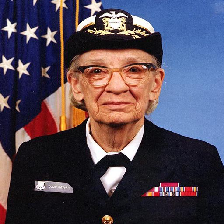

In [5]:
import numpy as np
import PIL.Image as Image

grace_hopper = tf.keras.utils.get_file('image.jpg','https://storage.googleapis.com/download.tensorflow.org/example_images/grace_hopper.jpg')
grace_hopper = Image.open(grace_hopper).resize(IMAGE_SHAPE)
grace_hopper


In [6]:
grace_hopper = np.array(grace_hopper)/255.0
grace_hopper.shape


(224, 224, 3)

In [7]:
result = classifier.predict(grace_hopper[np.newaxis, ...])
result.shape


(1, 1001)

Just checking what happens when eclipses are removed from parameter above.

In [9]:
result = classifier.predict(grace_hopper[np.newaxis])
result.shape

(1, 1001)

In [10]:
predicted_class = np.argmax(result[0], axis=-1)
predicted_class


653

Get the labels of imagenet.

In [11]:
labels_path = tf.keras.utils.get_file('ImageNetLabels.txt','https://storage.googleapis.com/download.tensorflow.org/data/ImageNetLabels.txt')
imagenet_labels = np.array(open(labels_path).read().splitlines())


16384/10484 [==============================================] - 0s 0us/step


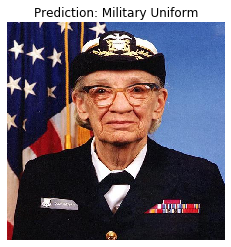

In [12]:
plt.imshow(grace_hopper)
plt.axis('off')
predicted_class_name = imagenet_labels[predicted_class]
_ = plt.title("Prediction: " + predicted_class_name.title())


Lets get the dataset for re-training for other use case.

In [13]:
data_root = tf.keras.utils.get_file(
  'flower_photos','https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz',
   untar=True)


228818944/228813984 [==============================] - 1s 0us/step


In [14]:
image_generator = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1/255)
image_data = image_generator.flow_from_directory(str(data_root), target_size=IMAGE_SHAPE)


Found 3670 images belonging to 5 classes.


In [15]:
for image_batch, label_batch in image_data:
  print("Image batch shape: ", image_batch.shape)
  print("Label batch shape: ", label_batch.shape)
  break


Image batch shape:  (32, 224, 224, 3)
Label batch shape:  (32, 5)


In [16]:
result_batch = classifier.predict(image_batch)
result_batch.shape


(32, 1001)

In [21]:
predicted_class_names = imagenet_labels[np.argmax(result_batch, axis=-1)]
predicted_class_names


array(['cardoon', 'purse', 'daisy', 'teddy', 'velvet', 'shower cap',
       'pot', 'bakery', 'coral fungus', 'picket fence', 'boathouse',
       'picket fence', 'daisy', 'daisy', 'daisy', 'daisy', 'corn',
       'daisy', 'lakeside', 'hummingbird', 'volcano', 'rapeseed', 'titi',
       'cardoon', 'sea urchin', 'sea urchin', 'daisy', 'pot',
       'American egret', 'corn', 'chainlink fence', 'quill'], dtype='<U30')

Output will show you that base model provides incorrect prediction on new data set. Justification is base model is used trained on different use case. For flowers we will need retrain with flower dataset.

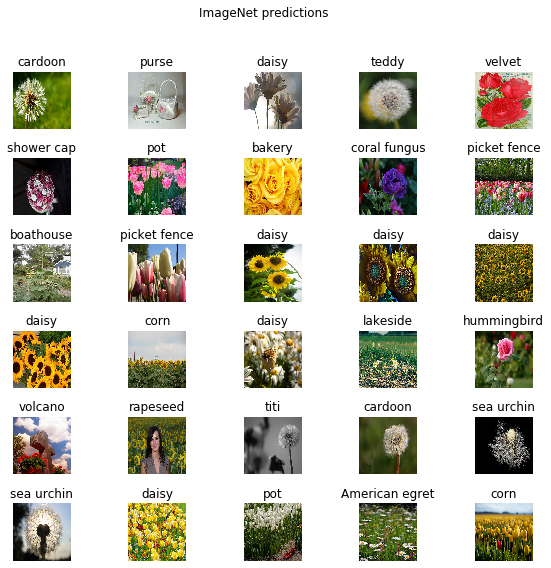

In [22]:
plt.figure(figsize=(10,9))
plt.subplots_adjust(hspace=0.5)
for n in range(30):
  plt.subplot(6,5,n+1)
  plt.imshow(image_batch[n])
  plt.title(predicted_class_names[n])
  plt.axis('off')
_ = plt.suptitle("ImageNet predictions")


Above predicted labels are wrong except some which were there in base model training.

**Lets start Retraining base model by fetching headless version.**